In [36]:
import pandas as pd
import joblib
import pm4py
import numpy as np

In [44]:
data = joblib.load("../../data/processed/data_clean.pkl")
data["key"] = data["id"].astype(str) + "-" + data["sessionId"].astype(str)

In [45]:
data["event"].value_counts()

LOAD_NEW_PAGE_PRODUCT        21430
VIDEO_PROGRESS               20230
DETAILS_VIEW                 15945
VIDEO_START                   8770
VIDEO_COMPLETE                6215
LOAD_NEW_PAGE_PROMOTION       2466
LOAD_NEW_PAGE_HOME            2235
LOAD_NEW_PAGE_SERVICE         2008
LOAD_NEW_PAGE_SEARCH          1592
LOAD_NEW_PAGE_INFO            1128
LOAD_NEW_PAGE_NEWS            1105
CLICK                          869
LOAD_NEW_PAGE_INSPIRATION      474
ADD_TO_CART                    380
FILTER_BY                      360
LOAD_NEW_PAGE_LEGAL            345
LOAD_NEW_PAGE_CHECKOUT         251
LOAD_NEW_PAGE_COMPARISON       219
LOAD_NEW_PAGE_SHOWROOM         202
LOAD_NEW_PAGE_COMPANY          115
DOWNLOAD                        76
LOAD_NEW_PAGE_ACCOUNT           62
CHECKOUT                        49
REMOVE_FROM_CART                40
LOAD_NEW_PAGE_JOBS              24
PAYMENT                          5
LOAD_NEW_PAGE_ERROR              1
Name: event, dtype: int64

In [100]:
n_cases_min = 2
n_cases_max = 10

n_seconds_min = 30
n_seconds_max = 200
channel = ["Organic Search"]
device = ["desktop"]
platform = ["Windows"]

events_needed = ["DOWNLOAD"]
events_excluded = ["LOAD_NEW_PAGE_ERROR", "LOAD_NEW_PAGE_JOBS"]

noise_cutoff = 0.2

In [86]:
filtered_data = pm4py.filter_case_size(data, n_cases_min, n_cases_max, case_id_key="key")

filtered_data = pm4py.filter_case_performance(filtered_data, n_seconds_min, n_seconds_max, 
                                       case_id_key="key", timestamp_key="activityTime")

filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="channelGrouping", 
                                                    values=channel, level="case", retain=True, 
                                                    case_id_key="key")
filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="deviceCategory", 
                                                    values=device, level="case", retain=True, 
                                                    case_id_key="key")
filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="platform", 
                                                    values=platform, level="case", retain=True, 
                                                    case_id_key="key")

filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="event", 
                                                    values=events_needed, level="case", retain=True, 
                                                    case_id_key="key")
filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="event", 
                                                    values=events_excluded, level="case", retain=False, 
                                                    case_id_key="key")

c:\Users\cosemti\.virtualenvs\ALGO-Smeg-tpBFOsly\lib\site-packages\pm4py\algo\filtering\pandas\cases\case_filter.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[element_group_size <= max_case_size]


In [91]:
model = pm4py.discover_dfg_typed(filtered_data, activity_key="event", timestamp_key="activityTime", case_id_key="key")
pm4py.view_dfg(model) #performance variation?

TypeError: view_performance_dfg() missing 2 required positional arguments: 'start_activities' and 'end_activities'

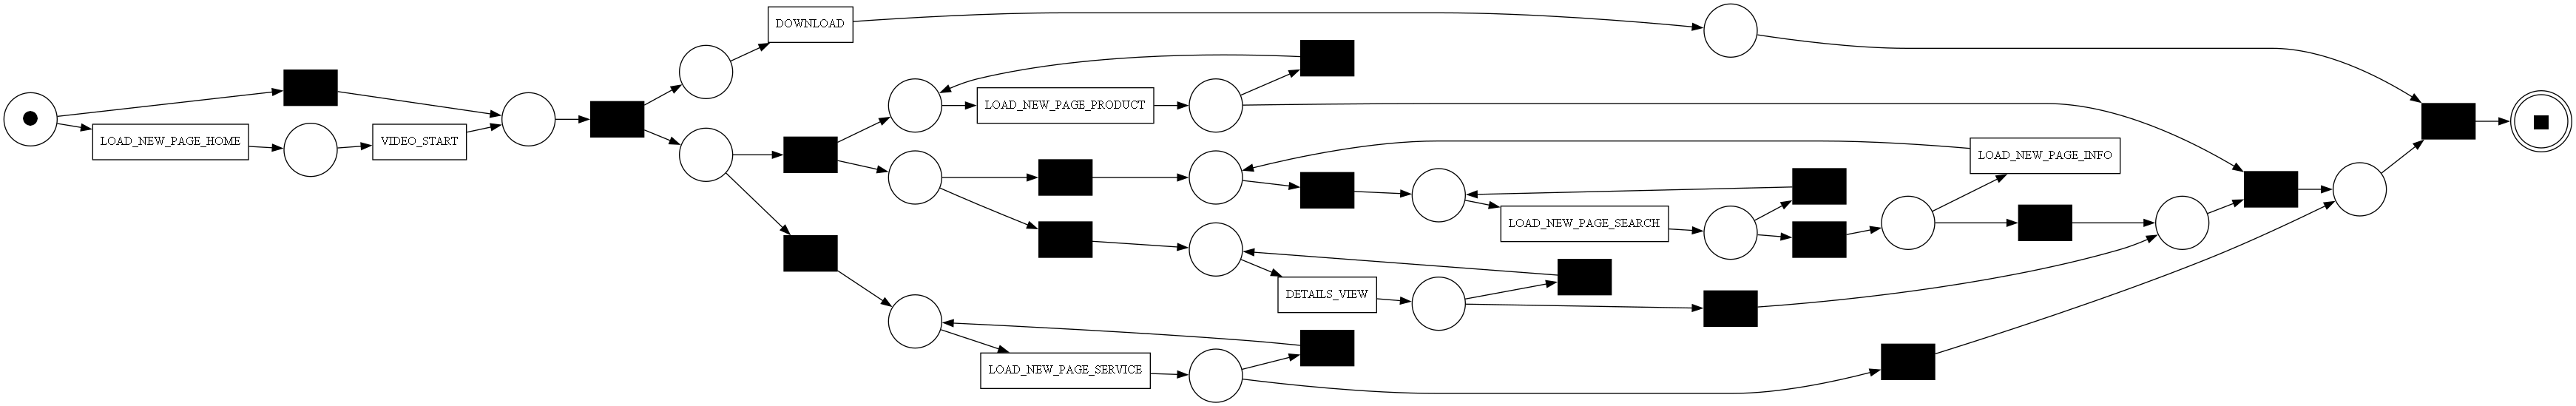

In [93]:
net, im, fm = pm4py.discover_petri_net_inductive(filtered_data, activity_key="event", timestamp_key="activityTime", case_id_key="key")
pm4py.view_petri_net(net, im, fm) 

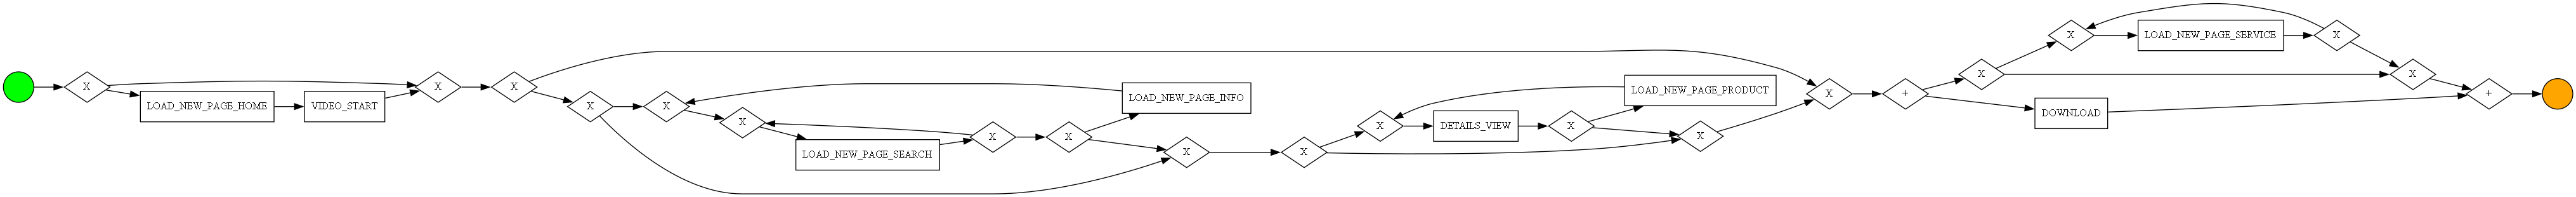

In [101]:
process_tree = pm4py.discover_process_tree_inductive(filtered_data, activity_key="event", timestamp_key="activityTime", case_id_key="key", 
                                                     noise_threshold=noise_cutoff)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

If there are a lot of skips (X) and then returns, this describes everything is possible. It is very difficult to get meaning out of this. Filters can solve a part of this problem. The frequency threshold can be increased, higher means a more simplified version. This is a parameter that requires tuning from the user side to get a reasonable description of the process.

TO DO: 
- welke visualisatie is het mooiste? 
- descriptieve grafieken van pm4py? 
- dashboard met parameters
- uitleg inductive miner
- vervolgstappen: A/B-testing input of recommender systems (paper)

In [43]:
pm4py.save_vis_bpmn(bpmn_model, "../../reports/figures/bpmn.png")